## CO2 flux analysis

This script gets the raw inversion data and calculates 

### Methods:

1. Load geometries and inversion CO2 data and preprocess as necessary.
2. Select the ROI (region of interest), initially using a small test region.
3. Create a grouping coordinate that divides growing and non-growing seasons.   
    - Initially this can be done manually. Later consider fitting a harmonic to divide seasons.  
4. For each year and season, calculate the CO2 flux sum.
5. For each year, get the difference between growing and non-growing season.
    - This is the CO2 flux amplitude that can then be related to atmospheric CO2 and driving variables. 


In [1]:
# Get all required packages
# import ee
# from osgeo import gdal
# from pyproj import CRS
# import geemap as gm

import rioxarray as rio
import os
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd

### General Settings

In [2]:
# Default data properties
nodata = -9999.0
epsg_crs = 4326

# Chose the inversion data version. Later (shorter) time series are driven by data from more stations.
inversion = 's99'  # Inversion starting year. Options: s85, s99, s06, s10

input_dir = '../data_input/'
output_dir = '../data_output/'

### Load data (geometries and co2) and do some initial processing

In [3]:
conts_file = os.path.join(input_dir, 'continents.geojson')
north50_file = os.path.join(input_dir, 'north50.geojson')
north30_file = os.path.join(input_dir, 'north30.geojson')
north0_file = os.path.join(input_dir, 'north0.geojson')
testrect_file = os.path.join(input_dir, 'testrect.geojson')

# Set the region to use for the analysis
roi = gpd.read_file(conts_file)

# testrect = gpd.read_file(conts_file)
# roi = roi.clip(testrect)

# Some printing and plotting to check 
# print(roi.crs)
# roi.plot()

In [4]:
# Open data, rename and set some attributes
file_path = '/Users/moyanofe/BigData/GeoSpatial/Carboscope/Inversions/' + inversion + 'oc_v2022_daily.nc'

# All three file reading methods read in the attributes differently.
# co2InvRaw = rio.open_rasterio(file_path)
# co2InvRaw = xr.open_dataset(file_path, engine="rasterio", variable='co2flux_land')
co2InvRaw_List = rio.open_rasterio(file_path, variable='co2flux_land')
co2InvRaw = co2InvRaw_List['co2flux_land']  # Extracting the dataarray from the list
co2InvRaw = co2InvRaw.rename({'mtime': 'time'})  # Rename the time dimension and coordinate to something standard.
co2InvRaw = co2InvRaw.rename({'x': 'longitude'})  # Rename the time dimension and coordinate to something standard.
co2InvRaw = co2InvRaw.rename({'y': 'latitude'})  # Rename the time dimension and coordinate to something standard.
co2InvRaw.attrs['units'] = 'PgC/yr'  # For some reason the units is a tuple of repeating values. Replacing with single value.
co2InvRaw.rio.write_crs(4326, inplace=True)  # Set the crs (I assume this is the correct one). This creates the spatial_ref coordinate.

# Setting nodata
# co2InvRaw.data = np.where(co2InvRaw.data == co2InvRaw.rio.nodata, nodata, co2InvRaw.data) # If there are any nodata values, replace them with the new definition
co2InvRaw = co2InvRaw.rio.write_nodata(nodata)  # Set the new nodata value
co2InvRaw = co2InvRaw.rio.write_nodata(co2InvRaw.rio.nodata, encoded=True, inplace=True)  # nodata value is enconded (not sure what this is or if necessary)

In [5]:
# Changing the flux to units per area (rather than per pixel)

# Read in the area per pixel data. The variable in the file contains 2 layers, of which the first seems to be land area.
pixarea_List = rio.open_rasterio(file_path, variable='area')
pixarea = pixarea_List['area']
pixarea = pixarea.rename({'x': 'longitude'})  # Rename the time dimension and coordinate to something standard.
pixarea = pixarea.rename({'y': 'latitude'})  # Rename the time dimension and coordinate to something standard.
landarea = pixarea[0]
landarea.attrs['units'] = 'm2'
landarea.coords.__delitem__('rt')

# Convert the co2 flux units: pixel to sqm, then to ha; and petagram to tons, so PgC y-1 -> tC ha-2 y-1
co2Inv = co2InvRaw / landarea * 10000 * 10**9 # to ha, to tons.

# Add some important attributes
co2Inv.attrs['units'] = 'tC/ha/y'
co2Inv.attrs['long_name'] = 'Land-Atmosphere CO2 flux'

In [6]:
# Select data from the region of interest
# co2InvT = co2Inv.rio.clip(testarea.geometry, testarea.crs, all_touched=True)
co2InvS = co2Inv.rio.clip(roi.geometry, roi.crs, all_touched=True)

### Calculating seasonal amplitudes and temporal amplitude trends

1. First create a 'groups' coordinate from the combination of years and seasons (winter vs summer).
2. Calculate the mean for each group (year-season).
3. Calculate the winter-summer difference (amplitudes) between means.
4. Calculate the temporal trends in the amplitudes.

In [7]:
# 1. Create a 'season' variable and then a 'groups' coordinate

months = co2InvS.time.dt.month.data # Extract the month values
# season = np.where(np.logical_or(months < 4, months > 9), 0, 1)
season = np.where((months < 4) | (months > 9), 0, 1)  # Split year in two periods of 6 months each (two seasons): 0 = Oct-Mar, 1 = Apr-Sep
groups = co2InvS.time.dt.year.data + (season/10)  # Create year-season groups for grouped calculations 
co2InvS['groups'] = ('time', groups)  # Set as coordinate

In [8]:
# 2. Calculate the mean for each year-season group and add again a years coordinate.

# co2InvTG = co2Inv.groupby(['time.year', 'season']).mean()  # Does not work! Grouping by two variables is not supported in xarray!
co2InvTG = co2InvS.groupby('groups').mean()  # Get the mean values of surface co2 fluxes by year-season

# Add again the coordinate representing years
years = np.round(co2InvTG.coords['groups'].data)
co2InvTG['year'] = ('groups', years)

# Check results:
# print(co2InvTG[0:,0,0])
# print(co2InvTG.coords['groups'])
# print(co2InvTG.coords['year'])
# co2InvTG.where(co2InvTG.year==1985, drop=True)

In [9]:
# 3. Calculate the difference between winter (positive) and summer (negative) mean fluxes. For the southern hemisphere the sign is corrected afterwards.

def diff(x):
    return(x[0] - x[1])  # Oct-Mar average flux minus Apr-Sep average flux. Signs are correct for NH. SH sign is corrected below.
co2InvTD = co2InvTG.groupby('year').map(diff)  # Apply the difference function for each year
co2InvTD = co2InvTD.where(co2InvTD.latitude > 0, co2InvTD * (-1))  # Correct the sign in the Southern Hemisphere

# Rename the xarray data array and setting the crs
co2InvTD = co2InvTD.rename('co2flux_yearlyamp')
co2InvTD.rio.write_crs(4326, inplace=True)

<xarray.DataArray 'co2flux_yearlyamp' (year: 23, latitude: 87, longitude: 144)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [nan, nan, nan, ..., nan, nan, -0.],
        [nan, nan, nan, ..., nan, nan, -0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [nan, nan, nan, ..., nan, nan, -0.],
        [nan, nan, nan, ..., nan, nan, -0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [nan, nan, nan, ..., nan, nan, -0.],
        [nan, nan, nan, ..., nan, nan, -0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [nan, nan, nan, ..., nan, nan, -0.],
        [nan, nan, nan, ..., nan, nan, -0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [nan, nan, nan, ..., nan, nan, -0.],
        [nan, nan, nan, ..., nan, nan, -0.]]])
Coordinates:
  * longitude    (longitude) float64 -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * latitude     (latitude) float64 83.0 81.0 79.0 77.0 ... -85.0 -87.0 -89.0
  * year         (year) float64 1.999e+03 2e+03 2.001e+03 ... 2.02e+03 2.021e+03
    spatial_ref  int64 0

In [10]:
# 4. Calculate temporal trends, mean, variance, etc in seasonal amplitudes

# Linear trend calculation
from xarrayutils.utils import linear_trend
fluxamp_stats = linear_trend(co2InvTD, 'year')
fluxamp_stats.slope.attrs['units'] = 'tC/ha/y'
fluxamp_stats.slope.attrs['long_name'] = 'Trend in seasonal CO2 flux amplitude'
fluxamp_stats.rio.write_crs(4326, inplace=True)

# Variance
fluxamp_var = co2InvTD.var(dim='year')
fluxamp_var.attrs['units'] = 'tC/ha/y'
fluxamp_var.attrs['long_name'] = 'Temporal variance in seasonal CO2 flux amplitude'
fluxamp_var.rio.write_crs(4326, inplace=True)
fluxamp_var = fluxamp_var.rename('co2fluxamp_variance')

# Mean
fluxamp_mean = co2InvTD.mean(dim='year')
fluxamp_mean.attrs['units'] = 'tC/ha/y'
fluxamp_mean.attrs['long_name'] = 'Temporal mean in seasonal CO2 flux amplitude'
fluxamp_mean.rio.write_crs(4326, inplace=True)
fluxamp_mean = fluxamp_mean.rename('co2fluxamp_mean')

fluxamp_stats['mean'] = fluxamp_mean
fluxamp_stats['variance'] = fluxamp_var

/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


### Save to file

In [11]:
# Saving data to file

# Saving the amp and amp-trend results to disk
file_out_amp = os.path.join(output_dir, 'CO2SeasAmpS_' + inversion + '.nc')
co2InvTD.to_netcdf(file_out_amp)

file_out_trend = os.path.join(output_dir, 'CO2SeasAmpStats_' + inversion + '.nc')
fluxamp_stats.to_netcdf(file_out_trend)


# Save the trend data to GeoTiff (useful if reading into Earth Engine is required)
# Saving the database (not as an array) keeps the band name info. (But seems like Earth Engine does not import band names)
# file_out = os.path.join(output_dir, 'co2invSeasAmpTrend_' + inversion + '.tif')
# fluxamp_trends.rio.to_raster(file_out)

# Save the co2 flux seasonal difference data to GeoTiff
# file_in = os.path.join(output_dir, 'co2invSeasAmp_' + inversion + '.nc')
# file_out = os.path.join(output_dir, 'co2invSeasAmp_' + inversion + '.tif')
# ds_fluxamp = rio.open_rasterio(file_in)
# # print(ds_fluxamp)
# da_fluxamp = ds_fluxamp['co2flux_yearlyamp']
# da_fluxamp.attrs = ds_fluxamp.attrs
# print(da_fluxamp.attrs)
# da_fluxamp.rio.to_raster(file_out)

### Plotting

/var/folders/8f/pswsw93d6klgw34_s99kdcgn1tv7l7/T/ipykernel_13827/3273948328.py:14: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(p1, label=co2InvS.isel(time=0).attrs['units'])


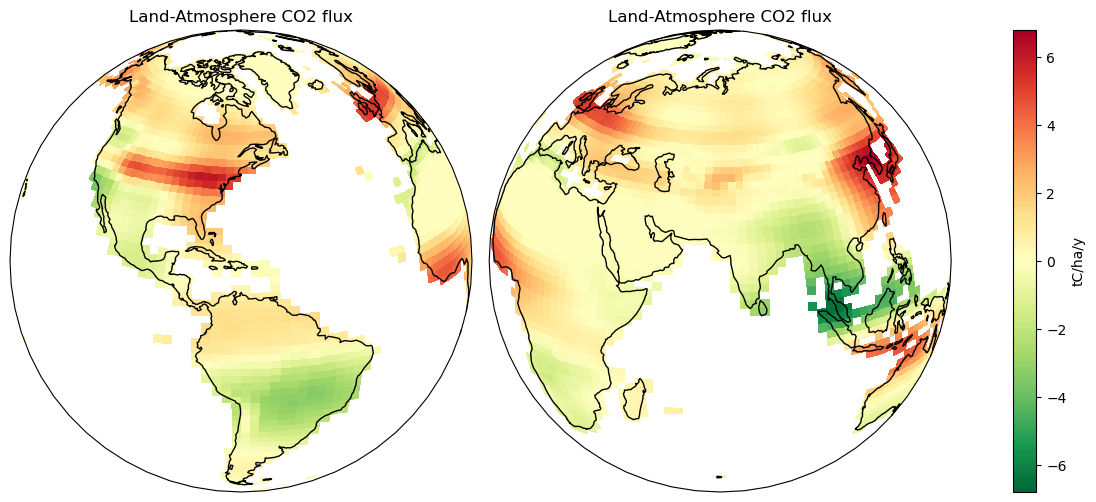

In [12]:
# Check flux data by plotting the first band
fig = plt.figure(figsize=[16,6])
ax1 = fig.add_subplot(121, projection = ccrs.Orthographic(-70, 20), facecolor="white")
ax2 = fig.add_subplot(111, projection = ccrs.Orthographic(70, 20), facecolor="white")
c_map=plt.cm.get_cmap('RdYlGn').reversed()
p1 = co2InvS.isel(time=0).plot(ax = ax1, transform=ccrs.PlateCarree(), cmap=c_map, add_colorbar=False)
p2 = co2InvS.isel(time=0).plot(ax = ax2, transform=ccrs.PlateCarree(), cmap=c_map, add_colorbar=False)
ax1.set_global()
ax1.coastlines()
ax1.set_title(co2InvS.isel(time=0).attrs['long_name'])
ax2.set_global()
ax2.coastlines()
ax2.set_title(co2InvS.isel(time=0).attrs['long_name'])
plt.colorbar(p1, label=co2InvS.isel(time=0).attrs['units'])
# plt.colorbar(p2, label=co2InvT.isel(time=0).attrs['units'])
plt.show()


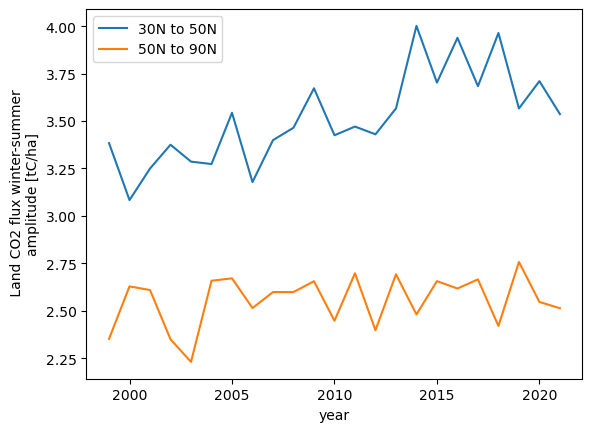

In [13]:
# Plotting of seasonal amplitude time series

# Calculate the spatial mean and plot.
# regDiffMean = co2InvTD.where(co2InvTD.latitude > 0).where(co2InvTD.latitude < 30).mean(['longitude','latitude'])
# The data is now a one dimensional time series, so it is plotted as a line graph.
# regDiffMean.plot(label='0N to 30N')
regDiffMean = co2InvTD.where(co2InvTD.latitude > 30).where(co2InvTD.latitude < 50).mean(['longitude','latitude'])
regDiffMean.plot(label='30N to 50N')
regDiffMean = co2InvTD.where(co2InvTD.latitude > 50).mean(['longitude','latitude'])
regDiffMean.attrs['units'] = 'tC/ha'  # Add the new units
regDiffMean.attrs['long_name'] = " Land CO2 flux winter-summer amplitude"
del regDiffMean['spatial_ref']  # Remove coordinate so it doesn't show as title.
regDiffMean.plot(label='50N to 90N')
plt.legend()

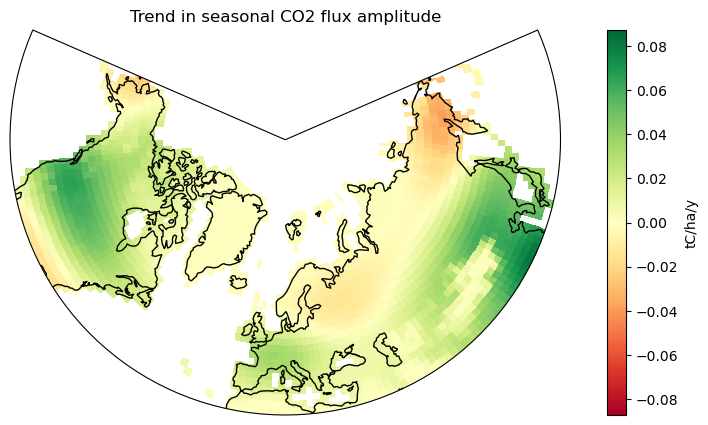

In [14]:
# Map plot of flux trends in the northern hemisphere
fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(
    111,
    projection = ccrs.LambertConformal(  # projection=ccrs.Orthographic(0, 90)
        central_longitude=10.0,
        central_latitude=39.0,
        false_easting=0.0,
        false_northing=0.0,
        standard_parallels=(33, 45),
        globe=None, cutoff=30),
    facecolor="white"
)
p = fluxamp_stats.slope.plot(
    ax = ax,
    transform=ccrs.PlateCarree(),
    cmap='RdYlGn',
    add_colorbar=False
)
ax.set_global()
ax.coastlines()
ax.set_title(fluxamp_stats.slope.attrs['long_name'])
plt.colorbar(p, label=fluxamp_stats.slope.attrs['units'])
plt.show()

/var/folders/8f/pswsw93d6klgw34_s99kdcgn1tv7l7/T/ipykernel_13827/2848678887.py:15: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(p1, label=fluxamp_stats.slope.attrs['units'])


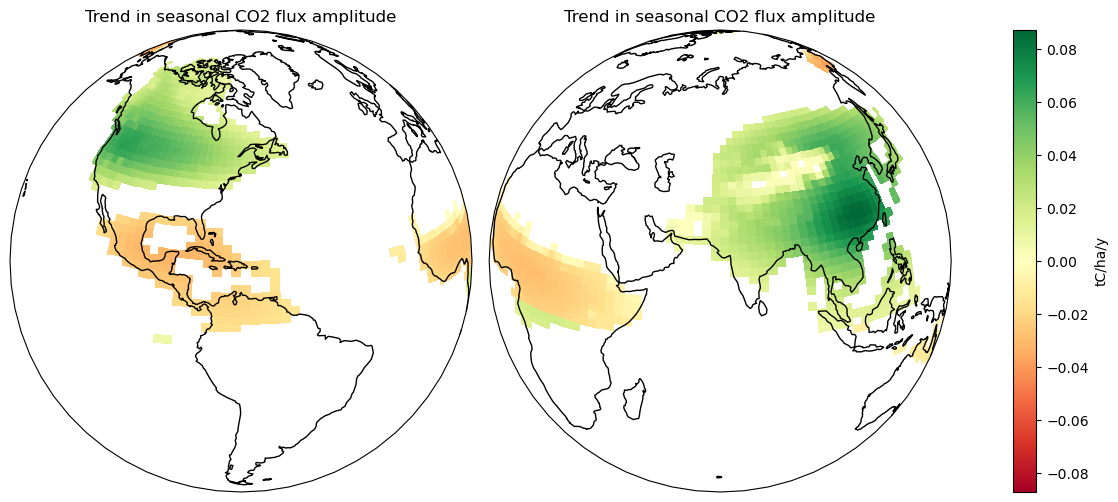

In [15]:
# Map plot of flux trends globally
# Plot the region of interest
fig = plt.figure(figsize=[16,6])
ax1 = fig.add_subplot(121, projection = ccrs.Orthographic(-70, 20), facecolor="white")
ax2 = fig.add_subplot(111, projection = ccrs.Orthographic(70, 20), facecolor="white")
fluxamp_trends_sig = fluxamp_stats.slope.where(fluxamp_stats.p_value < 0.1) # Change the p+value limit to filter for trend significance
p1 = fluxamp_trends_sig.plot(ax = ax1, transform=ccrs.PlateCarree(), cmap='RdYlGn', add_colorbar=False)
p2 = fluxamp_trends_sig.plot(ax = ax2, transform=ccrs.PlateCarree(), cmap='RdYlGn', add_colorbar=False)
ax1.set_global()
ax1.coastlines()
ax1.set_title(fluxamp_stats.slope.attrs['long_name'])
ax2.set_global()
ax2.coastlines()
ax2.set_title(fluxamp_stats.slope.attrs['long_name'])
plt.colorbar(p1, label=fluxamp_stats.slope.attrs['units'])
# plt.colorbar(p2, label=co2InvT.isel(time=0).attrs['units'])
plt.show()